In [62]:
import acoular as ac
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as anim
#conda install -c conda-forge ffmpeg   


In [63]:

dataName = '2025-01-28_15-01-02_954236'

resFolderName = 'out/beamforming_results_25_02_16/'+dataName

cameraPosition = 2

currentFrequencyBand = 3
currentFrame = 60

# Camera Angles
azimuth =  np.array([-133.33136452241695,164.2465834869733])
elevation = np.array([-27.020027669675454,64.11592446841624])

# cameraAngles = np.array([[-133.33136452241695,-27.020027669675454],[164.2465834869733,64.11592446841624]]) # 
bassoon_low_xyz = [0.97081132, 0.98296962, 0.41316809]
bassoon_high_xyz = [0.53056959, 0.3204048, 1.48546785]


# Open and read the JSON file
with open(resFolderName + '/evaluation_config.json', 'r') as file:
    config_data = json.load(file)

# Access the output folder path
out_folder = config_data['out_folder']
print(f"Output Folder: {out_folder}")

# read Data
result = np.load(resFolderName+ '/result_'+dataName + ".npy")
map = ac.fbeamform.L_p(result) # p0 = 4 * 10**-4

maxValue = np.max(map)
minValue = np.min(map[currentFrequencyBand])
mapNormalized = (map - minValue) / (maxValue - minValue)
resolution = config_data['calc_grid_res_meters']
frequencyBands = config_data['frequency_bands']
frameRate = config_data['frame_rate_fps']

print(maxValue)
print(minValue)
print(map.shape)

Output Folder: ./evaluation/out/
87.0281329700549
-350.0
(5, 772, 25, 25, 36)


In [64]:
map_flat = map[currentFrequencyBand, currentFrame].flatten()

# get indices of 50 highest values
number_of_points_per_frame = 10
top_indices = np.argpartition(map_flat, -number_of_points_per_frame)[-number_of_points_per_frame:]



x_m, y_m, z_m = np.meshgrid(np.linspace(0,map.shape[2]*resolution,map.shape[2]),
                            np.linspace(0,map.shape[3]*resolution,map.shape[3]), 
                            np.linspace(0,map.shape[4]*resolution,map.shape[4]))

x_m_flat = x_m.flatten()[top_indices]
y_m_flat = y_m.flatten()[top_indices]
z_m_flat = z_m.flatten()[top_indices]
top_values = map_flat[top_indices]


# Set a threshold
noise_floor_dB = 40  

# Filter the points above the threshold
above_threshold = top_values > noise_floor_dB
x_m_thresh = x_m_flat[above_threshold]
y_m_thresh = y_m_flat[above_threshold]
z_m_thresh = z_m_flat[above_threshold]
top_values_thresh = top_values[above_threshold]

print(len(top_values))
print(len(top_values_thresh))

10
6


1692.1843910440552


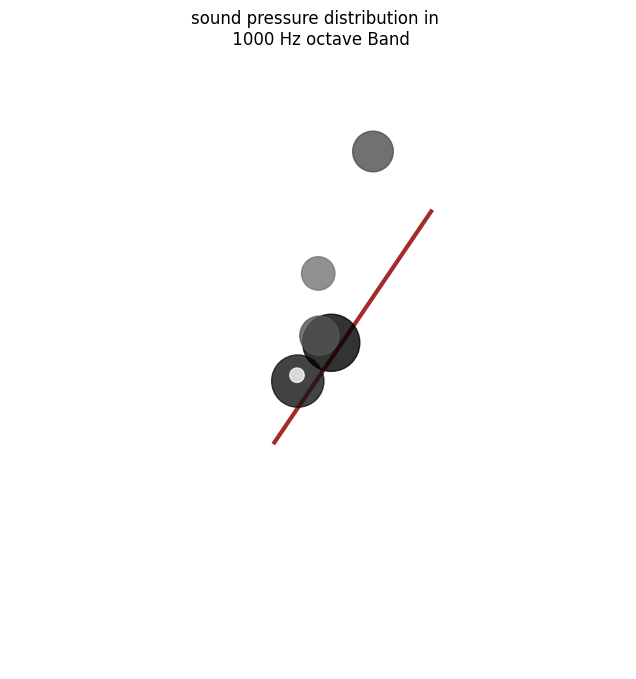

In [71]:
dotsize = 10**-6
size = (top_values_thresh)**5 * dotsize

print(np.max(size))


fig = plt.figure(figsize = [10,8])
ax = fig.add_subplot(projection='3d')
ax.set_proj_type('persp', focal_length=0.1)#0.547)

ax.view_init(elev=elevation[cameraPosition-1]-10, 
             azim=azimuth[cameraPosition-1]+15, 
             roll=0)

# bassoon:
x_line = [bassoon_low_xyz[0], bassoon_high_xyz[0]]
y_line = [bassoon_low_xyz[1], bassoon_high_xyz[1]]
z_line = [bassoon_low_xyz[2], bassoon_high_xyz[2]]
ax.plot(x_line, y_line, z_line, linewidth=3, color='brown')



scat = ax.scatter(x_m_thresh, y_m_thresh, z_m_thresh,
                  c=top_values_thresh,
                  cmap="grey_r",
                  alpha=0.8,
                  s=size)

#plt.colorbar(ax)
ax.set_title('sound pressure distribution in \n '+str(frequencyBands[currentFrequencyBand])+' Hz octave Band')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

#ax.set_xlim(map.shape[2]*resolution, 0)
#ax.set_ylim(0, map.shape[3]*resolution)
#ax.set_zlim(0, map.shape[4]*resolution)

ax.set_xlim(1.4, 0.2)
ax.set_ylim(0, 1.4)
ax.set_zlim(0, 2)

ax.set_aspect('equal')

# Set the elevation and azimuth angles
#ax.view_init(elev=90, azim=0)  # Elevation of 30 degrees and azimuth of 45 degrees
#
## Remove the grey background and tick lines
#ax.xaxis.pane.fill = True
#ax.yaxis.pane.fill = True
#ax.zaxis.pane.fill = True
#ax.xaxis.pane.set_facecolor('green')
#ax.yaxis.pane.set_facecolor('green')
#ax.zaxis.pane.set_facecolor('green')
#ax.grid(False)
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
ax.set_axis_off()


# update function also works with global variables
def update(frame):
    
    # Extract values for this specific frame
    values = map[currentFrequencyBand, frame, :, :, :].flatten()
    
    # Apply a threshold to filter the data
    mask = values > noise_floor_dB  # Define a threshold for visibility
    filtered_values = values[mask]
    
    # Get the coordinates for these filtered values
    x_filtered = x_m.flatten()[mask]
    y_filtered = y_m.flatten()[mask]
    z_filtered = z_m.flatten()[mask]
    
    # Update color, size, alpha
    color = filtered_values  # Can apply normalization or scaling
    size = (filtered_values ** 5) * dotsize  # Adjust size based on values
        
    # Update the scatter plot with new values
    scat._offsets3d = (x_filtered, y_filtered, z_filtered)  # Update the 3D coordinates
    scat.set_array(color)  # Update color
    scat.set_sizes(size)  # Update size
    
    return scat,

ani = anim.FuncAnimation(fig=fig, func=update, frames=map.shape[1], interval=(1/25)*1000) # todo get framerate from config file

plt.show()

os.makedirs('out/video_data/', exist_ok=True)
resFileName = 'out/video_data/'+dataName+'_camera_'+str(cameraPosition)+'.mp4'
ani.save(filename=resFileName, writer="ffmpeg")